## Bayesian Model with Proactiv Data

In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [2]:
from arviz.utils import Numba
Numba.disable_numba()

In [3]:
data = pd.read_csv('original_dataset_proactiv.csv')

In [4]:
X = data.iloc[:, :9]
y = data['Revenue']

In [5]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [6]:
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_YouTube_MediaCost, sat_YouTube_MediaCost, coef_YouTube_MediaCost, car_Snapchat_MediaCost, sat_Snapchat_MediaCost, coef_Snapchat_MediaCost, car_Radio_MediaCost, sat_Radio_MediaCost, coef_Radio_MediaCost, car_Pinterest_MediaCost, sat_Pinterest_MediaCost, coef_Pinterest_MediaCost, car_GoogleSearch_MediaCost, sat_GoogleSearch_MediaCost, coef_GoogleSearch_MediaCost, car_Facebook_MediaCost, sat_Facebook_MediaCost, coef_Facebook_MediaCost, car_DV360_MediaCost, sat_DV360_MediaCost, coef_DV360_MediaCost, car_BingSearch_MediaCost, sat_BingSearch_MediaCost, coef_BingSearch_MediaCost, car_Amazon_MediaCost, sat_Amazon_MediaCost, coef_Amazon_MediaCost]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 215 seconds.
There were 649 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5682492433818398, but should be close to 0.8. Try to increase the number of tuning steps.
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 315 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7097122142931854, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026387D02610>,
      dtype=object)

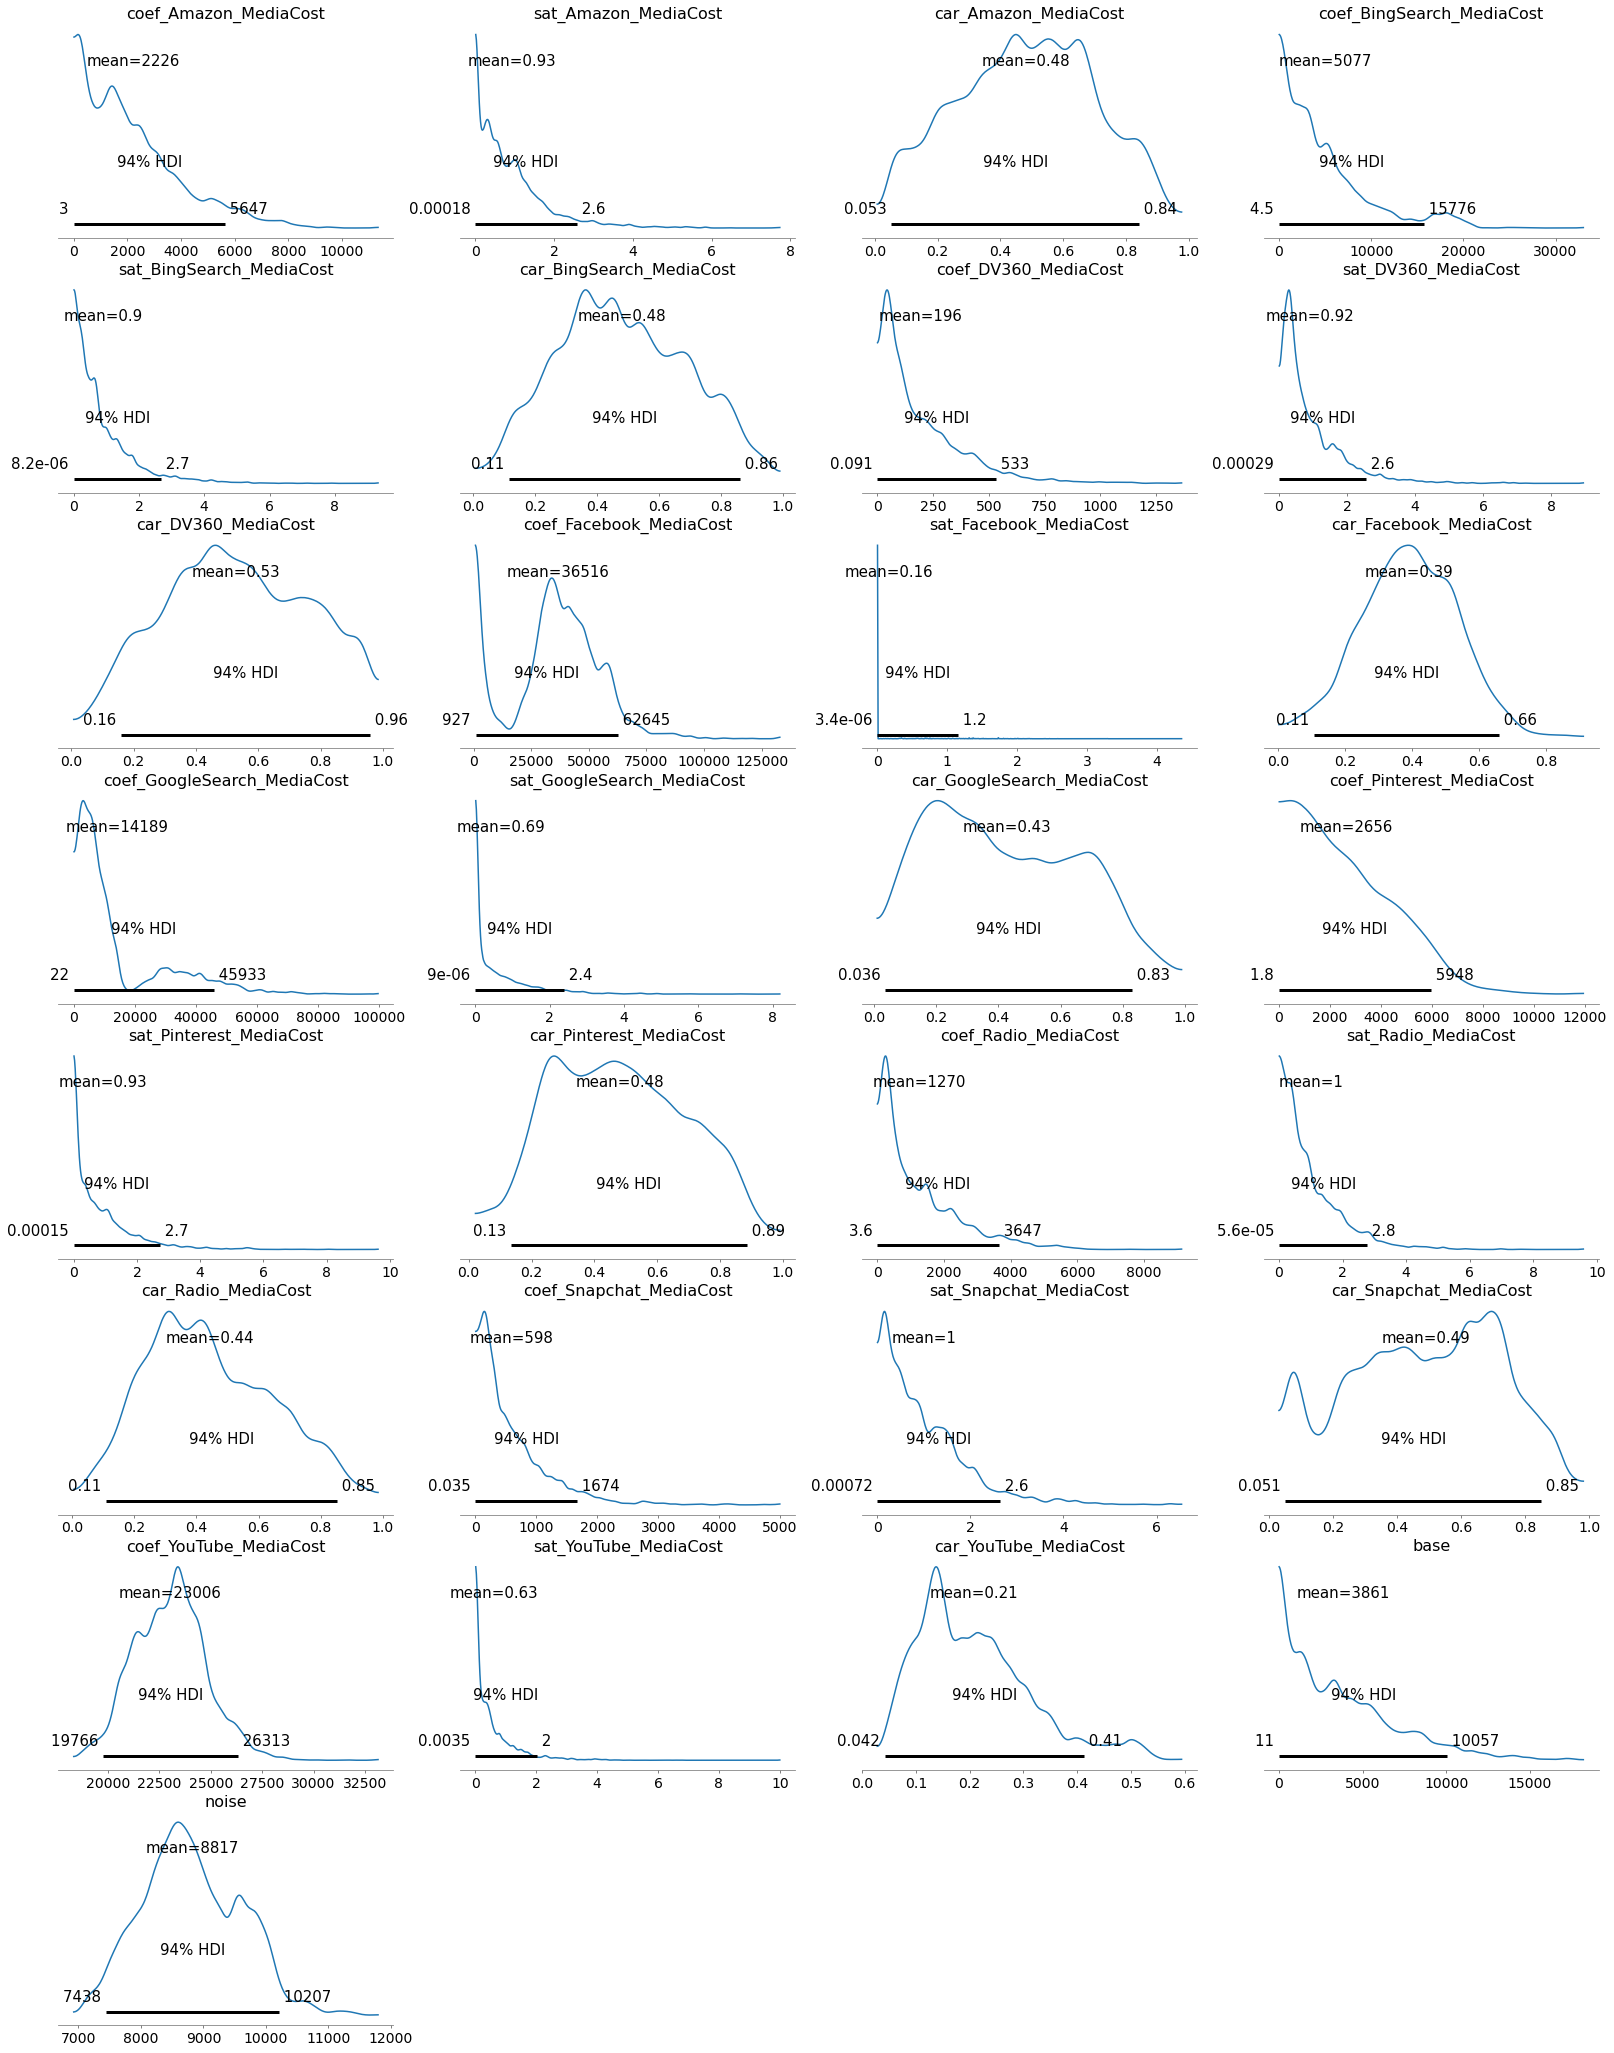

In [7]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

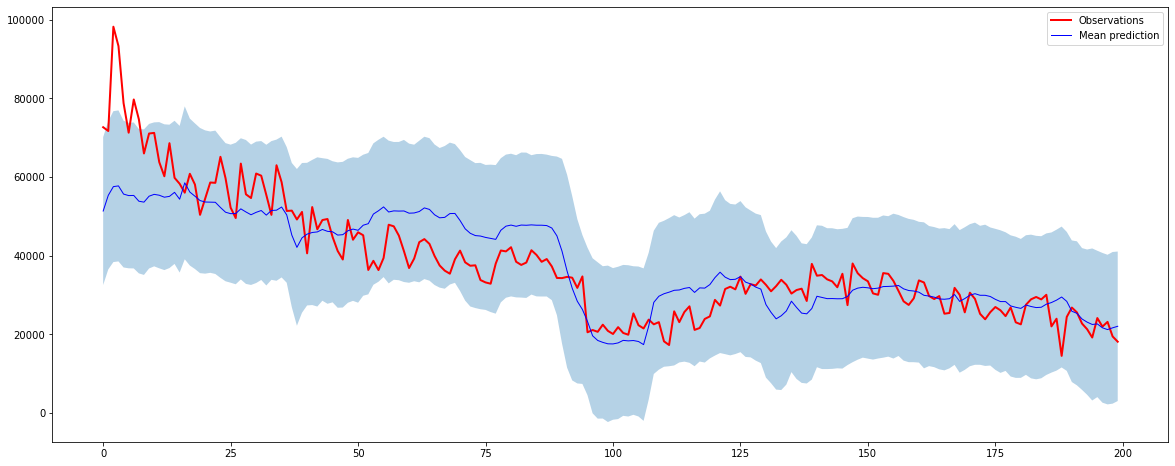

In [8]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

In [10]:
X.columns

Index(['Amazon_MediaCost', 'BingSearch_MediaCost', 'DV360_MediaCost',
       'Facebook_MediaCost', 'GoogleSearch_MediaCost', 'Pinterest_MediaCost',
       'Radio_MediaCost', 'Snapchat_MediaCost', 'YouTube_MediaCost'],
      dtype='object')

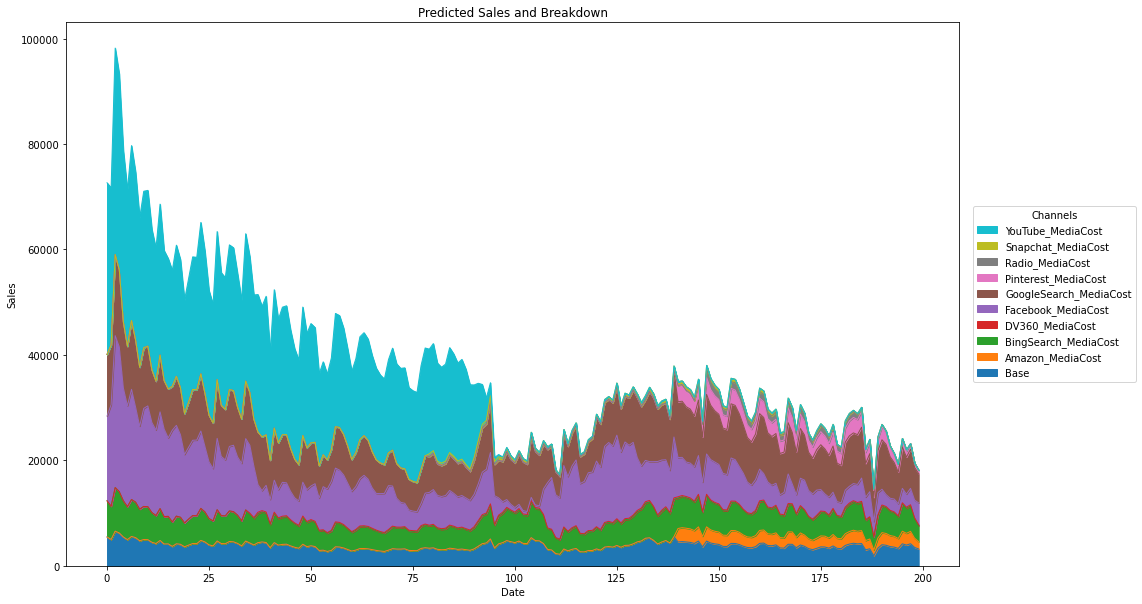

In [11]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 200)
            .mean(0)
           )
channels = X.columns.values
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)
for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

In [13]:
adj_contributions.head()

,Base,Amazon_MediaCost,BingSearch_MediaCost,DV360_MediaCost,Facebook_MediaCost,GoogleSearch_MediaCost,Pinterest_MediaCost,Radio_MediaCost,Snapchat_MediaCost,YouTube_MediaCost
0,5464.592518,0.0,6859.737764,0.0,16074.722598,11697.582486,0.0,0.0,0.0,32557.514635
1,5000.054838,0.0,6289.176403,0.0,19275.552288,11331.789202,0.0,0.0,0.0,29792.727268
2,6573.288100,0.0,8269.981398,0.0,28818.759289,15374.751604,0.0,0.0,0.0,39166.989609
3,6226.331646,0.0,7833.372708,0.0,27457.302152,14660.651743,0.0,0.0,0.0,37099.691751
4,5457.776894,0.0,6863.471777,0.0,21400.658870,12538.700512,0.0,0.0,0.0,32520.241946


In [15]:
unadj_contributions.sum(axis=1)

0      51335.031141
1      55359.321551
2      57684.174220
3      57843.576315
4      55733.468370
           ...     
195    22334.185003
196    21662.858863
197    21354.628839
198    21549.085089
199    21985.564979
Length: 200, dtype: float64

In [14]:
unadj_contributions.head()

,Base,Amazon_MediaCost,BingSearch_MediaCost,DV360_MediaCost,Facebook_MediaCost,GoogleSearch_MediaCost,Pinterest_MediaCost,Radio_MediaCost,Snapchat_MediaCost,YouTube_MediaCost
0,3861.101218,0.0,4846.864931,0.0,11357.869924,8265.126785,0.0,0.0,0.0,23004.068283
1,3861.101218,0.0,4856.576069,0.0,14884.808433,8750.541046,0.0,0.0,0.0,23006.294785
2,3861.101218,0.0,4857.726417,0.0,16927.927835,9031.016326,0.0,0.0,0.0,23006.402425
3,3861.101218,0.0,4857.666862,0.0,17026.947618,9091.430320,0.0,0.0,0.0,23006.430297
4,3861.101218,0.0,4855.559279,0.0,15139.884175,8870.496680,0.0,0.0,0.0,23006.427017


In [17]:
import pygal
from IPython.display import SVG, display

In [18]:
def show(chart):
    display(SVG(chart.render(disable_xml_declaration=True)))

In [27]:
def attribution(target="Revenue"):
    def compute_mean(trace, channel):
        return (trace
                .posterior[f'contribution_{channel}']
                .values
                .reshape(4000, 200)
                .mean(0)
               )
    channels = X.columns.values
    unadj_contributions = pd.DataFrame(
        {'Base': trace.posterior['base'].values.mean()},
        index=X.index
    )
    for channel in channels:
        unadj_contributions[channel] = compute_mean(trace, channel)
    adj_contributions = (unadj_contributions
                         .div(unadj_contributions.sum(axis=1), axis=0)
                         .mul(y, axis=0)
                        )
    
    line_chart = pygal.StackedLine(fill=True, explicit_size=True, height=600, width=1000, legend_at_bottom=True, title="Attribution", x_title="Day", y_title=f"{target}")
    for col in adj_contributions.columns:
        line_chart.add(col, adj_contributions[col].values)
    show(line_chart)

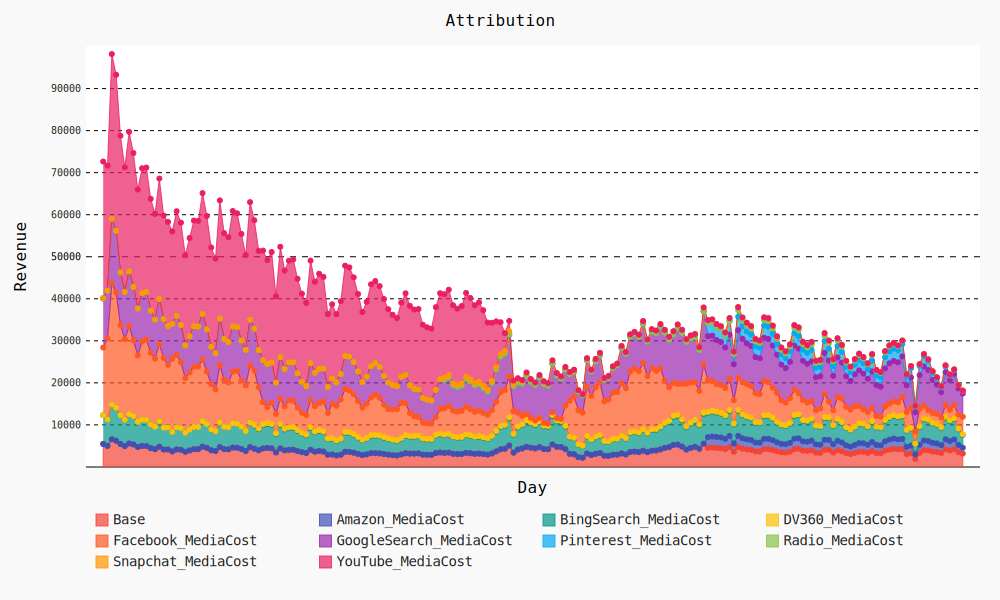

In [28]:
attribution()

In [29]:
if None:
    print(4)